### 1. IMPORT PACKAGES

In [95]:
#!pip install pandas numpy yfinance matplotlib
#!pip install scikit-learn
#!pip install torch

In [96]:
# Data Preprocessing
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn


### 2. DATASET

In [130]:
# Set the start and end dates
start_date = '2018-01-01'
end_date = '2020-12-01'

# Download TSLA data
tsla_price_df = yf.download('TSLA', start=start_date, end=end_date)
tsla_price_df.index = pd.to_datetime(tsla_price_df.index)

# Split the dataset into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(tsla_price_df, test_size=0.2, shuffle=False)


[*********************100%***********************]  1 of 1 completed


In [131]:
tsla_price_df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2018-01-02 00:00:00+00:00,21.368668,21.368668,21.474001,20.733334,20.799999,65283000
2018-01-03 00:00:00+00:00,21.150000,21.150000,21.683332,21.036667,21.400000,67822500
2018-01-04 00:00:00+00:00,20.974667,20.974667,21.236668,20.378668,20.858000,149194500
2018-01-05 00:00:00+00:00,21.105333,21.105333,21.149332,20.799999,21.108000,68868000
2018-01-08 00:00:00+00:00,22.427334,22.427334,22.468000,21.033333,21.066668,147891000


In [132]:
tsla_price_df.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2020-11-23 00:00:00+00:00,173.949997,173.949997,175.333328,167.263336,167.833328,150780900
2020-11-24 00:00:00+00:00,185.126663,185.126663,186.663330,175.399994,180.133331,160945500
2020-11-25 00:00:00+00:00,191.333328,191.333328,191.333328,181.789993,183.353333,146790600
2020-11-27 00:00:00+00:00,195.253326,195.253326,199.593338,192.816666,193.720001,112683300
2020-11-30 00:00:00+00:00,189.199997,189.199997,202.600006,184.836670,200.736664,189009300


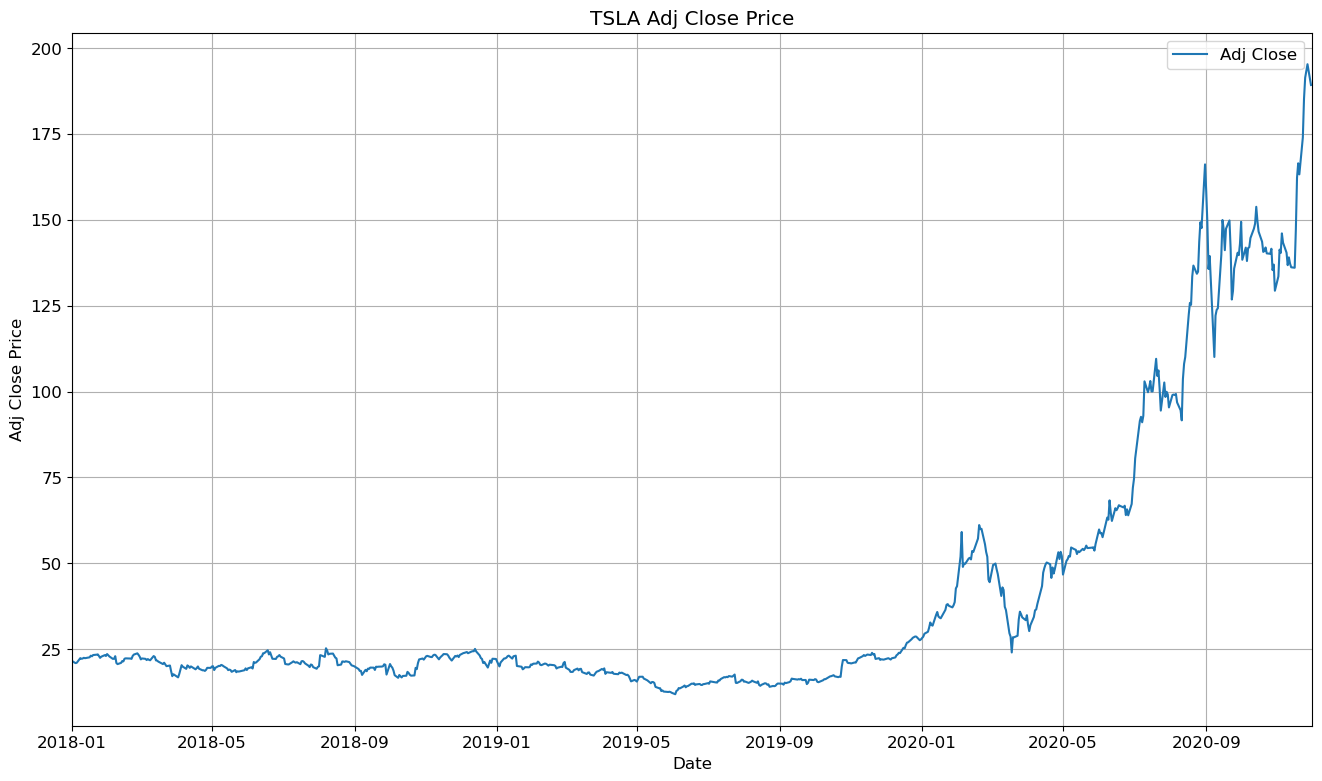

In [133]:
start_time_all = datetime.datetime(2018, 1, 1) # 2020-01-01
end_time_train = datetime.datetime(2020, 6, 30) # 2020-09-30
end_time_all = datetime.datetime(2020, 12, 1) # 2020-12-31

# Features variables (Close price, High price, Low price, Open price, Volume)
X = tsla_price_df.iloc[:, 1:6]

# Traget variable (Adj Close price)
y = tsla_price_df.iloc[:, 0:1]

# TSLA Adj Close price from 2020-01-01 to 2020-12-31
plt.plot(tsla_price_df.index, y, label='Adj Close')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.xlim(start_time_all, end_time_all)
plt.title('TSLA Adj Close Price')
plt.legend()
plt.show()

### 3. Normalizing and converting data

In [134]:
# Normalize the features (Close, High, Low, Open, Volume)
features = ['Close', 'High', 'Low', 'Open', 'Volume']
scaler_features = MinMaxScaler()
train_features = scaler_features.fit_transform(train_df[features])
test_features = scaler_features.transform(test_df[features])

# Create a new DataFrame with the normalized features
train_features_df = pd.DataFrame(train_features, columns=features, index=train_df.index)
test_features_df = pd.DataFrame(test_features, columns=features, index=test_df.index)

# Normalize the target column ('Adj Close') separately
scaler_target = MinMaxScaler(feature_range=(0, 1))
train_target = scaler_target.fit_transform(train_df[['Adj Close']].values)
test_target = scaler_target.transform(test_df[['Adj Close']].values)

# Print the first records of normalized data and the dimensions of the tensors
print("First records of normalized data (features):")
print(train_features_df.head())

print("\nFirst records of normalized data (target):")
print(train_target[:5])

First records of normalized data (features):
                              Close      High       Low      Open    Volume
Date                                                                       
2018-01-02 00:00:00+00:00  0.191699  0.173116  0.185089  0.176320  0.032264
2018-01-03 00:00:00+00:00  0.187257  0.177129  0.191373  0.188443  0.035160
2018-01-04 00:00:00+00:00  0.183696  0.168565  0.177741  0.177492  0.127934
2018-01-05 00:00:00+00:00  0.186350  0.166890  0.186470  0.182543  0.036352
2018-01-08 00:00:00+00:00  0.213203  0.192174  0.191304  0.181708  0.126448

First records of normalized data (target):
[[0.19169887]
 [0.18725711]
 [0.1836956 ]
 [0.18634981]
 [0.21320336]]


In [142]:
# Function to create data sequences for the LSTM model
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

# Set the sequence length
seq_length = 30
X_train, y_train = create_sequences(train_target, seq_length)
X_test, y_test = create_sequences(test_target, seq_length)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f"\nDimensions of the data for the LSTM model:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Dimensions of the data for the LSTM model:
X_train shape: torch.Size([557, 30, 1])
y_train shape: torch.Size([557, 1])
X_test shape: torch.Size([117, 30, 1])
y_test shape: torch.Size([117, 1])


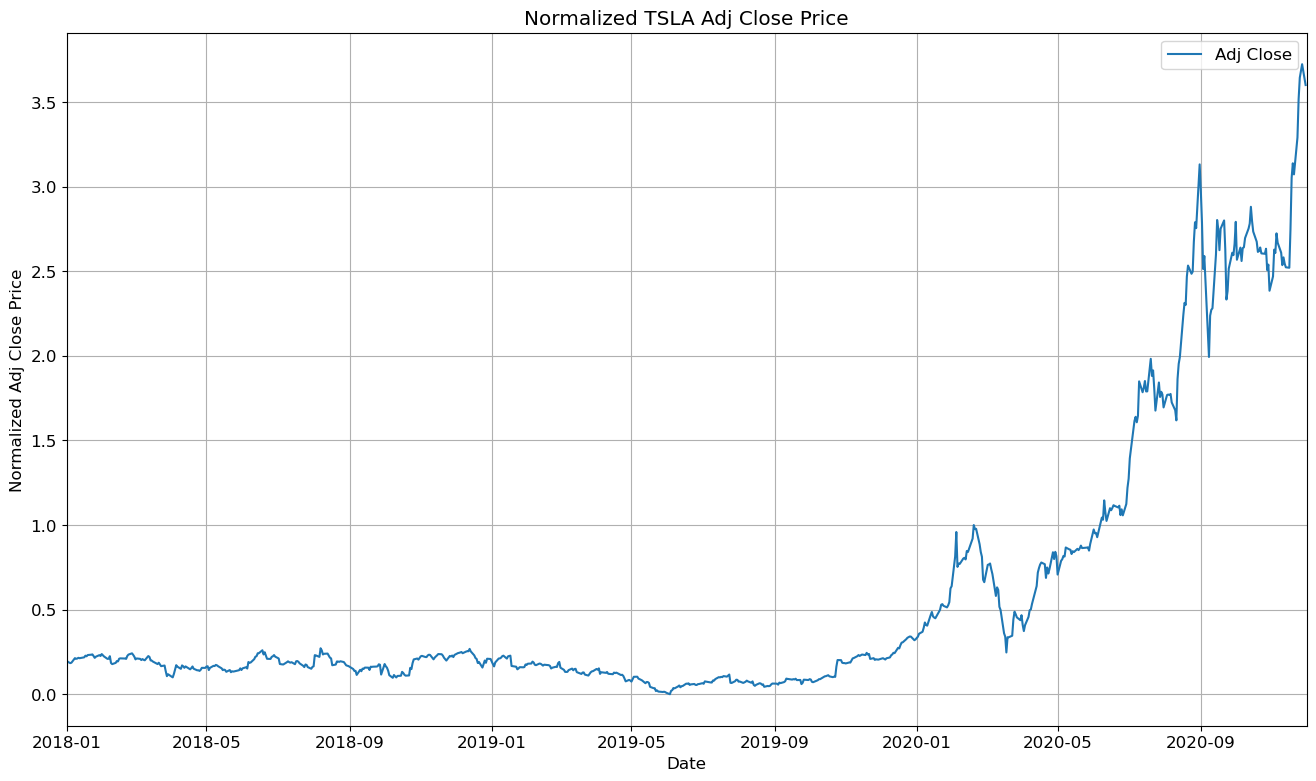

In [ ]:
# 
plt.plot(tsla_price_df.index, scaler_target.transform(tsla_price_df[['Adj Close']]), label='Adj Close')
plt.xlabel('Date')
plt.ylabel('Normalized Adj Close Price')
plt.xlim(start_time_all, end_time_all)
plt.title('Normalized TSLA Adj Close Price')
plt.legend()
plt.show()

In [147]:
# Definir la clase LSTMModel con batch_first=True
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Tamaño de batch ajustado para h0 y c0
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        
        return out

# Initialize model, loss function, and optimizer
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 3: Training the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/1000], Loss: 0.0346
Epoch [20/1000], Loss: 0.0314
Epoch [30/1000], Loss: 0.0285
Epoch [40/1000], Loss: 0.0209
Epoch [50/1000], Loss: 0.0084
Epoch [60/1000], Loss: 0.0064
Epoch [70/1000], Loss: 0.0052
Epoch [80/1000], Loss: 0.0042
Epoch [90/1000], Loss: 0.0035
Epoch [100/1000], Loss: 0.0031
Epoch [110/1000], Loss: 0.0028
Epoch [120/1000], Loss: 0.0025
Epoch [130/1000], Loss: 0.0023
Epoch [140/1000], Loss: 0.0022
Epoch [150/1000], Loss: 0.0020
Epoch [160/1000], Loss: 0.0018
Epoch [170/1000], Loss: 0.0017
Epoch [180/1000], Loss: 0.0017
Epoch [190/1000], Loss: 0.0017
Epoch [200/1000], Loss: 0.0017
Epoch [210/1000], Loss: 0.0016
Epoch [220/1000], Loss: 0.0016
Epoch [230/1000], Loss: 0.0016
Epoch [240/1000], Loss: 0.0016
Epoch [250/1000], Loss: 0.0016
Epoch [260/1000], Loss: 0.0016
Epoch [270/1000], Loss: 0.0015
Epoch [280/1000], Loss: 0.0015
Epoch [290/1000], Loss: 0.0015
Epoch [300/1000], Loss: 0.0015
Epoch [310/1000], Loss: 0.0014
Epoch [320/1000], Loss: 0.0014
Epoch [330/1000],

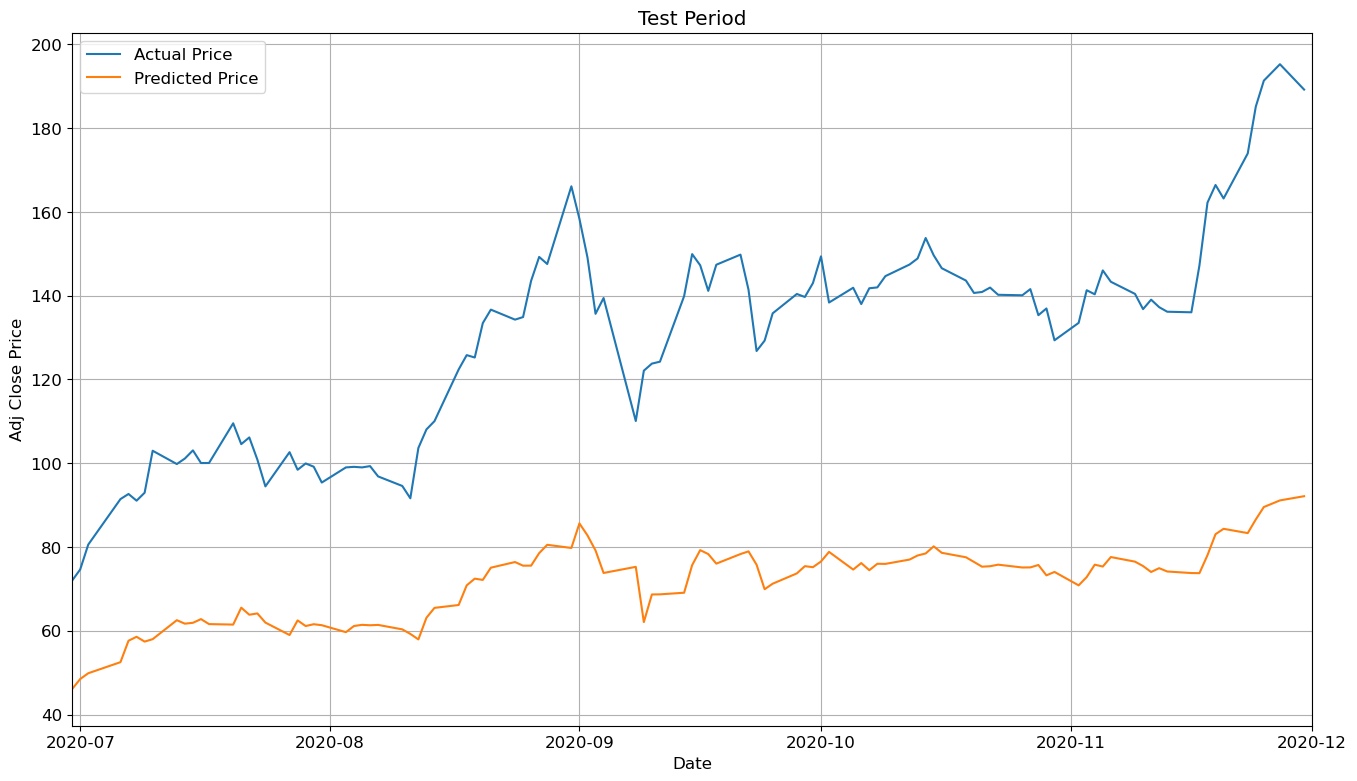

In [149]:
# Generate predictions on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# Rescale the predicted and actual values
y_pred_rescaled = scaler_target.inverse_transform(y_pred)
y_test_rescaled = scaler_target.inverse_transform(y_test.numpy())

# Adaptation of the plotting function
def plt_graph(start_time, end_time, period, val_line=False):
    # Plot actual adjusted close price
    plt.plot(test_df.index[seq_length:], y_test_rescaled, label='Actual Price')
    # Plot predicted adjusted close price
    plt.plot(test_df.index[seq_length:], y_pred_rescaled, label='Predicted Price')
    
    if val_line:
        plt.axvline(x=end_time_train, c='r', linestyle='--')
    
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.xlim(start_time, end_time)
    plt.title(f'{period} Period')
    plt.legend()
    plt.show()

# Use the plotting function
plt_graph(start_time=end_time_train, end_time=end_time_all, period='Test')